In [1]:
pip install --user yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
# pip install pandas-datareader

In [3]:
start='1900-1-01'
end  ='2020-7-11'
# data_source = 'yahoo'

In [4]:
# from pandas_datareader import data
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### VOO example

In [5]:
VOO = yf.Ticker("VOO")
VOO = VOO.history(start=start, end=end)
VOO.head(4)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-09-09,83.68,83.68,82.57,82.71,26500,0.0,0.0
2010-09-10,83.01,83.15,82.70,83.09,8600,0.0,0.0
2010-09-13,84.05,84.20,83.68,84.13,33700,0.0,0.0
2010-09-14,83.95,84.48,83.58,84.12,59400,0.0,0.0


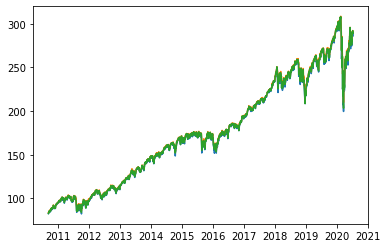

In [6]:
plt.plot(VOO['Low'])
plt.plot(VOO['High'])
plt.plot(VOO['Close'])

# EDA

shortest_ETF: UST 2010-02-02 00:00:00


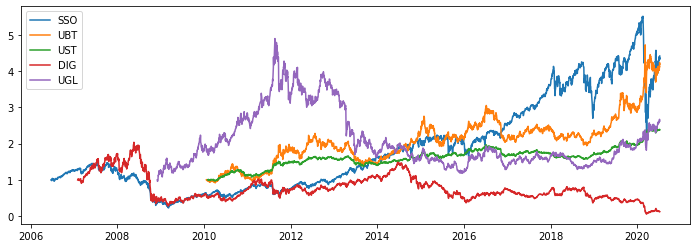

In [7]:
list_of_ETF_names =         ['SSO','UBT', 'UST','DIG','UGL']
asset_fraction_RayDalio =   [  0.3,  0.4,  0.15,0.075,0.075]

list_of_ETFs = []

for ETF_names in list_of_ETF_names:
  tmp = yf.Ticker(ETF_names)
  list_of_ETFs.append(tmp.history(start=start, end=end).copy())
    
    
def get_index(ETFname):
  for i,name in enumerate(list_of_ETF_names):
    if name==ETFname:
      return i

shortest_days = 5000
    
plt.figure(figsize=(12,4))
for i,item in enumerate(list_of_ETFs):
  if shortest_days > len(item['Close']):
    shortest_days = len(item['Close'])
    shortest_ETF = list_of_ETF_names[i]
  plt.plot(item['Close']/item['Close'][0])
plt.legend(list_of_ETF_names)

first_day = list_of_ETFs[get_index(shortest_ETF)].index[0]
print('shortest_ETF:', shortest_ETF, first_day)

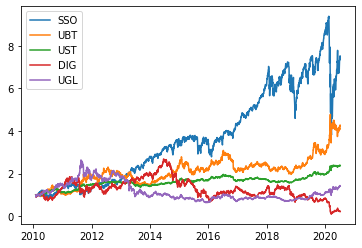

In [8]:
for i,item in enumerate(list_of_ETFs):
  list_of_ETFs[i] = item[first_day:]
plt.legend(list_of_ETF_names)

for item in list_of_ETFs:
  plt.plot(item['Close']/item['Close'][0])
plt.legend(list_of_ETF_names)

### TEST: Prilimirary portfolio vs Raydalio All weather

In [9]:
def get_portfolio(asset_fraction):

  portfolio = pd.DataFrame(list_of_ETFs[0]['Close'].copy())
  portfolio['Close'] = 10000.0
  
  asset_value = portfolio.iloc[0]['Close']
  for iDate in range(1,len(portfolio['Close'])):
    asset_value = portfolio.iloc[iDate-1]['Close']
    asset_value_change = 0
    for iETF,ETF in enumerate(list_of_ETFs):
      changes_ratio = ETF.iloc[iDate]['Close']/ETF.iloc[iDate-1]['Close'] - 1.0
      asset_value_change = asset_value_change + asset_value*asset_fraction[iETF]*changes_ratio
      asset_value_change = asset_value_change + asset_value*asset_fraction[iETF]/ETF.iloc[iDate]['Close']*ETF.iloc[iDate]['Dividends']
    asset_value = asset_value + asset_value_change
    portfolio.iloc[iDate]['Close'] = asset_value

  return portfolio

In [10]:
portfolio_RayDalio = get_portfolio(asset_fraction_RayDalio)

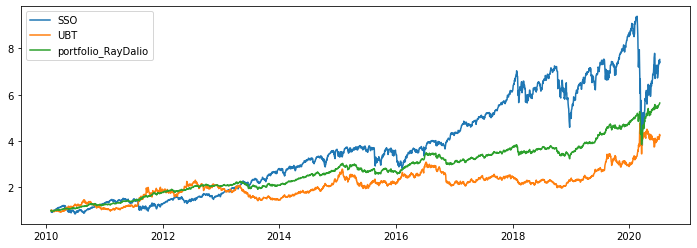

In [11]:
plt.figure(figsize=(12,4))
item = list_of_ETFs[get_index('SSO')]
plt.plot(item['Close']/item['Close'][0])
item = list_of_ETFs[get_index('UBT')]
plt.plot(item['Close']/item['Close'][0])

plt.plot(portfolio_RayDalio['Close']/portfolio_RayDalio['Close'][0])

plt.legend([list_of_ETF_names[get_index('SSO')],
            list_of_ETF_names[get_index('UBT')],
            'portfolio_RayDalio'])

In [12]:
def get_linear_model(asset_hist):
  n_days = len(asset_hist)
  momentum = (asset_hist[-1]/asset_hist[0]-1.0)/n_days
  diff = asset_hist/asset_hist[0] - momentum*range(n_days)
  return momentum, diff


# performace_measure_duration = 21 ~ approximate 3 month
# tolarable volatility / momentum = 0.7

def get_portfolio_performance_based_on_linear_model(asset_fraction):
  asset_fraction_tmp = np.array(asset_fraction)
  asset_fraction_tmp = asset_fraction_tmp/np.sum(asset_fraction_tmp)
  portfolio = get_portfolio(asset_fraction_tmp)
  Momentum = []
  volatility = []
  for i in range(len(portfolio['Close'] -21)):
    tmp = portfolio['Close'][i:i+21]
    p, diff = get_linear_model(tmp)
    std = np.std(diff)
    Momentum.append(p)
    volatility.append(std)

  return np.array(Momentum) - 0.7*np.array(volatility)

In [13]:
# Exponential Moving Average (EMA)
s = 2.0 # smoothing param
d = 60  # averaging duration

def get_EMA(asset_hist):
  EMA = [np.mean(asset_hist[0:d])]
  for i in range(d,len(asset_hist)):
    EMA.append(asset_hist[i]*s/(1.0+d) + EMA[-1]*(1.0-s/(1.0+d)))
  
  return pd.Series(EMA,index=asset_hist.index[d-1:])

In [14]:
EMAs = {'SSO':get_EMA(list_of_ETFs[get_index('SSO')]['Close']),
        'UBT':get_EMA(list_of_ETFs[get_index('UBT')]['Close']),
        'RayDalio':get_EMA(portfolio_RayDalio['Close'])}

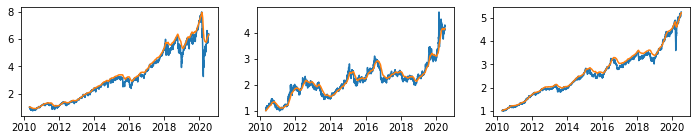

In [15]:
plt.figure(figsize=(12,2))
plt.subplot(1,3,1)
plt.plot(list_of_ETFs[get_index('SSO')]['Close'][d-1:]/list_of_ETFs[get_index('SSO')]['Close'][d-1])
plt.plot(EMAs['SSO']/EMAs['SSO'][0])

plt.subplot(1,3,2)
plt.plot(list_of_ETFs[get_index('UBT')]['Close'][d-1:]/list_of_ETFs[get_index('UBT')]['Close'][d-1])
plt.plot(EMAs['UBT']/EMAs['UBT'][0])

plt.subplot(1,3,3)
plt.plot(portfolio_RayDalio['Close'][d-1:]/portfolio_RayDalio['Close'][d-1])
plt.plot(EMAs['RayDalio']/EMAs['RayDalio'][0])

In [16]:
# performace measure similar to Sharpe Ratio
# measure = normalized gain  / ( normalzied std + epsilon)
epsilon = 0.003  # fractional tolerable volatility
dd = 100 # performance measure duration 

def get_performance_based_on_EMA(asset_hist):
  EMA = get_EMA(asset_hist)
  DIFF = asset_hist[d-1:]/EMA - 1.0
  performance = []
  for i in range(len(EMA)-dd):
    performance.append( (asset_hist[d-1+i+dd]/asset_hist[d-1+i]-1.0) / (np.std(DIFF[i:i+dd])+epsilon) )
  return np.mean(performance)/(np.std(performance)+epsilon)

In [17]:
print('SSO performace:',  get_performance_based_on_EMA(list_of_ETFs[get_index('SSO')]['Close']) )
print('UBT performace:',  get_performance_based_on_EMA(list_of_ETFs[get_index('UBT') ]['Close']) )
print('RayDalio performace:',  get_performance_based_on_EMA(portfolio_RayDalio['Close']))

SSO performace: 0.8328367009778143
UBT performace: 0.40967388669700217
RayDalio performace: 0.8851178623956697


### Optimize portfolio: 

In [18]:
from scipy import optimize
from copy import deepcopy as copy

In [19]:
def obj(asset_fraction):
  asset_fraction_tmp = np.array(asset_fraction)
  asset_fraction_tmp = asset_fraction_tmp/np.sum(asset_fraction_tmp)
  portfolio = get_portfolio(asset_fraction_tmp)
  performance = get_performance_based_on_EMA(portfolio['Close'])
  return -performance

In [20]:
list_of_ETF_names

['SSO', 'UBT', 'UST', 'DIG', 'UGL']

In [21]:
bounds = [(asset_fraction_RayDalio[i]*0.75,asset_fraction_RayDalio[i]*1.25) for i in range(len(list_of_ETF_names))]

In [22]:
result = optimize.differential_evolution(obj,bounds,disp=True,popsize=8,workers=8)

/home/kilean/anaconda3/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= -0.973205
differential_evolution step 2: f(x)= -0.973308
differential_evolution step 3: f(x)= -0.974662
differential_evolution step 4: f(x)= -0.984727
differential_evolution step 5: f(x)= -0.984727
differential_evolution step 6: f(x)= -0.98858
differential_evolution step 7: f(x)= -0.98858
differential_evolution step 8: f(x)= -0.98858


In [23]:
result

     fun: -0.9978627200021833
     jac: array([-4.55399474e-01,  2.33844799e-01, -2.33146835e-06,  1.02370123e+00,
        7.65128394e-01])
 message: 'Optimization terminated successfully.'
    nfev: 384
     nit: 8
 success: True
       x: array([0.375     , 0.3       , 0.15135769, 0.05625   , 0.05625   ])

In [24]:
result.x = result.x/np.sum(result.x)
portfolio = get_portfolio(result.x)

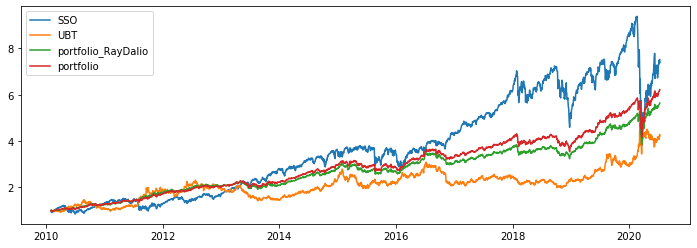

In [25]:
plt.figure(figsize=(12,4))
item = list_of_ETFs[get_index('SSO')]
plt.plot(item['Close']/item['Close'][0])
item = list_of_ETFs[get_index('UBT')]
plt.plot(item['Close']/item['Close'][0])

plt.plot(portfolio_RayDalio['Close']/portfolio_RayDalio['Close'][0])
plt.plot(portfolio['Close']/portfolio['Close'][0])

plt.legend([list_of_ETF_names[get_index('SSO')],
            list_of_ETF_names[get_index('UBT')],
            'portfolio_RayDalio',
            'portfolio'])

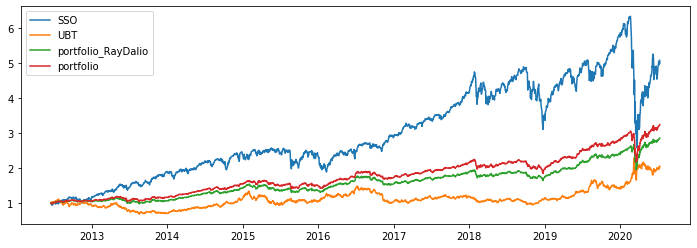

In [28]:
d_from = 600

plt.figure(figsize=(12,4))
item = list_of_ETFs[get_index('SSO')]
plt.plot(item['Close'][d_from:]/item['Close'][d_from])
item = list_of_ETFs[get_index('UBT')]
plt.plot(item['Close'][d_from:]/item['Close'][d_from])

plt.plot(portfolio_RayDalio['Close'][d_from:]/portfolio_RayDalio['Close'][d_from])
plt.plot(portfolio['Close'][d_from:]/portfolio['Close'][d_from])

plt.legend([list_of_ETF_names[get_index('SSO')],
            list_of_ETF_names[get_index('UBT')],
            'portfolio_RayDalio',
            'portfolio'])

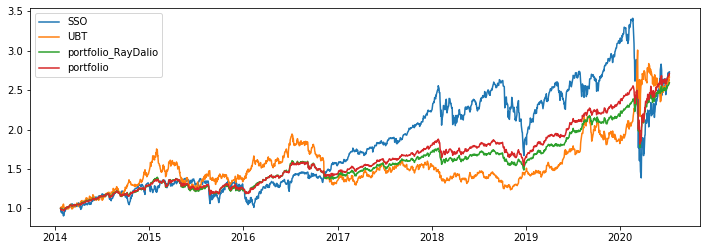

In [31]:
d_from = 1000

plt.figure(figsize=(12,4))
item = list_of_ETFs[get_index('SSO')]
plt.plot(item['Close'][d_from:]/item['Close'][d_from])
item = list_of_ETFs[get_index('UBT')]
plt.plot(item['Close'][d_from:]/item['Close'][d_from])

plt.plot(portfolio_RayDalio['Close'][d_from:]/portfolio_RayDalio['Close'][d_from])
plt.plot(portfolio['Close'][d_from:]/portfolio['Close'][d_from])

plt.legend([list_of_ETF_names[get_index('SSO')],
            list_of_ETF_names[get_index('UBT')],
            'portfolio_RayDalio',
            'portfolio'])

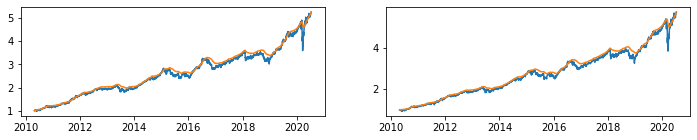

In [32]:
plt.figure(figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(portfolio_RayDalio['Close'][d-1:]/portfolio_RayDalio['Close'][d-1])
plt.plot(EMAs['RayDalio']/EMAs['RayDalio'][0])

EMAs['portfolio']=get_EMA(portfolio['Close'])
plt.subplot(1,2,2)
plt.plot(portfolio['Close'][d-1:]/portfolio['Close'][d-1])
plt.plot(EMAs['portfolio']/EMAs['portfolio'][0])

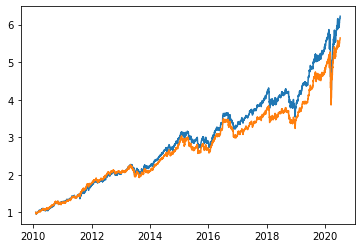

In [43]:
n=0
plt.plot(portfolio['Close'][n:]/portfolio['Close'][n])
plt.plot(portfolio_RayDalio['Close'][n:]/portfolio_RayDalio['Close'][n])

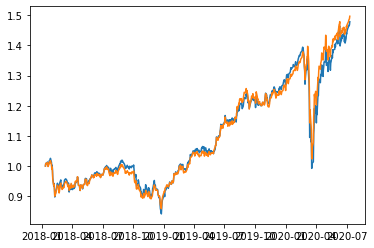

In [42]:
n=2000
plt.plot(portfolio['Close'][n:]/portfolio['Close'][n])
plt.plot(portfolio_RayDalio['Close'][n:]/portfolio_RayDalio['Close'][n])

In [37]:
for i,ETFname in enumerate(list_of_ETF_names):
    print(ETFname,result.x[i],asset_fraction_RayDalio[i])

SSO 0.3994215549295293 0.3
UBT 0.3195372439436235 0.4
UST 0.16121473464798838 0.15
DIG 0.05991323323942939 0.075
UGL 0.05991323323942939 0.075


# From ratio to number of shares

In [38]:
prices = []
for ETF in list_of_ETFs:
    prices.append(ETF['Close'][-1])

In [39]:
len(list_of_ETFs)

5

In [40]:
def get_portfolio_shares(asset_Value,asset_fraction,prices):
    shares = {}
    for i,ETFname in enumerate(list_of_ETF_names):
        shares[ETFname]=asset_Value*asset_fraction[i]/prices[i]
    return shares

In [41]:
shares = get_portfolio_shares(10000,result.x,prices)
shares

{'SSO': 30.172348914453035,
 'UBT': 23.232313795523012,
 'UST': 21.23202089397977,
 'DIG': 8.947615477812038,
 'UGL': 9.21175172807955}